In [1]:
!unzip Images.zip

Archive:  Images.zip
  inflating: Images/42845.jpg        
  inflating: Images/428451.jpg       
  inflating: Images/428452.jpg       
  inflating: Images/428461.jpg       
  inflating: Images/428462.jpg       
  inflating: Images/42847.jpg        
  inflating: Images/428472.jpg       
  inflating: Images/42848.jpg        
  inflating: Images/428481.jpg       
  inflating: Images/428482.jpg       
  inflating: Images/428483.jpg       
  inflating: Images/42849.jpg        
  inflating: Images/428491.jpg       
  inflating: Images/428492.jpg       
  inflating: Images/42850.jpg        
  inflating: Images/428501.jpg       
  inflating: Images/428503.jpg       
  inflating: Images/airplane_001.jpg  
  inflating: Images/airplane_002.jpg  
  inflating: Images/airplane_003.jpg  
  inflating: Images/airplane_004.jpg  
  inflating: Images/airplane_005.jpg  
  inflating: Images/airplane_006.jpg  
  inflating: Images/airplane_007.jpg  
  inflating: Images/airplane_008.jpg  
  inflating: Images/a

In [2]:
!unzip Airplanes_Annotations.zip

Archive:  Airplanes_Annotations.zip
  inflating: Airplanes_Annotations/42845.csv  
  inflating: Airplanes_Annotations/428451.csv  
 extracting: Airplanes_Annotations/428452.csv  
  inflating: Airplanes_Annotations/428461.csv  
 extracting: Airplanes_Annotations/428462.csv  
 extracting: Airplanes_Annotations/42847.csv  
  inflating: Airplanes_Annotations/428472.csv  
 extracting: Airplanes_Annotations/42848.csv  
 extracting: Airplanes_Annotations/428481.csv  
  inflating: Airplanes_Annotations/428482.csv  
  inflating: Airplanes_Annotations/428483.csv  
  inflating: Airplanes_Annotations/42849.csv  
  inflating: Airplanes_Annotations/428491.csv  
 extracting: Airplanes_Annotations/428492.csv  
  inflating: Airplanes_Annotations/42850.csv  
 extracting: Airplanes_Annotations/428501.csv  
 extracting: Airplanes_Annotations/428503.csv  
  inflating: Airplanes_Annotations/airplane_001.csv  
  inflating: Airplanes_Annotations/airplane_002.csv  
 extracting: Airplanes_Annotations/airplane_0

In [3]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [4]:
path = "Images"
annot = "Airplanes_Annotations"

airplane_050.jpg


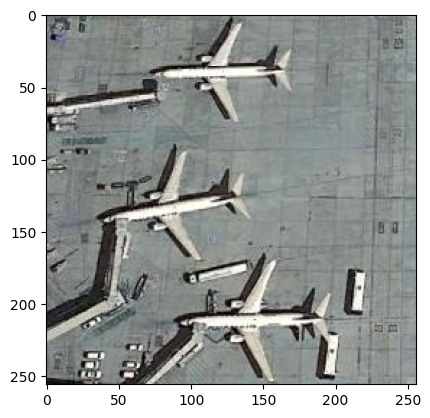

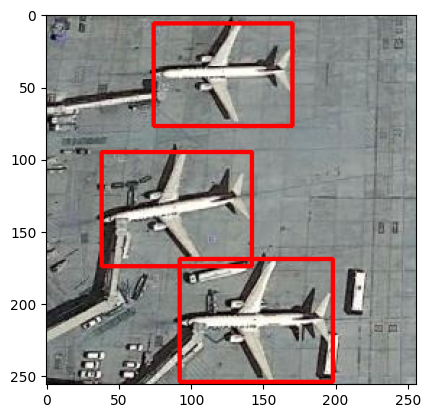

In [5]:
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

In [6]:
# To Perform Selective search Use open-Cv
!pip install opencv-contrib-python

In [7]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

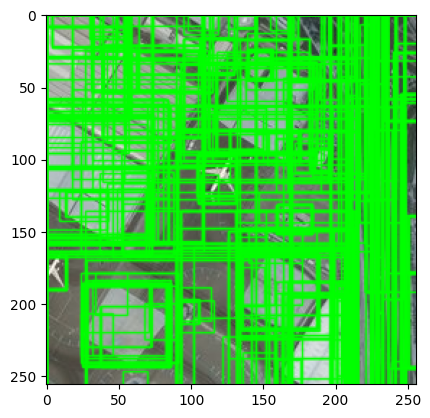

In [8]:
im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [9]:
train_images=[]
train_labels=[]

In [10]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [11]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [12]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})

            # Set input image for selective search
            ss.setBaseImage(image)

            # Switch to a fast but less accurate mode
            ss.switchToSelectiveSearchFast()

            # Run selective search on the input image
            ssresults = ss.process()
            # The results obtained from the Selective Search algorithm
            #  (ss.process()) are typically arranged based on their "quality"
            # or likelihood of containing an object. The algorithm works by
            # hierarchically merging smaller regions into larger ones, and the
            #  resulting regions are ranked based on their similarity and other
            #  criteria.

            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                # Access individual region coordinates (x, y, width, height)
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                        #Idea Here Point(4): https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_050.jpg
1 airplane_110.jpg
2 airplane_056.jpg
3 airplane_047.jpg
5 airplane_067.jpg
6 airplane_053.jpg
inside
7 airplane_078.jpg
8 airplane_085.jpg
inside
10 airplane_091.jpg
11 airplane_032.jpg
12 airplane_184.jpg
13 airplane_105.jpg
14 airplane_063.jpg
15 airplane_158.jpg
16 airplane_153.jpg
17 airplane_162.jpg
18 airplane_017.jpg
19 airplane_023.jpg
20 airplane_033.jpg
21 airplane_002.jpg
22 airplane_125.jpg
23 airplane_074.jpg
24 airplane_176.jpg
25 airplane_084.jpg
26 airplane_042.jpg
27 airplane_086.jpg
28 airplane_167.jpg
29 airplane_008.jpg
31 airplane_046.jpg
32 airplane_188.jpg
33 airplane_186.jpg
34 airplane_037.jpg
35 airplane_161.jpg
36 airplane_038.jpg
37 airplane_069.jpg
38 airplane_092.jpg
39 airplane_195.jpg
40 airplane_043.jpg
41 airplane_128.jpg
42 airplane_124.jpg
43 airplane_140.jpg
44 airplane_131.jpg
45 airplane_060.jpg
48 airplane_015.jpg
49 airplane_145.jpg
51 airplane_010.jpg
52 airplane_151.jpg
inside
53 airplane_108.jpg
inside
54 airplane_064.jpg


In [13]:
X_new = np.array(train_images)
del train_images
y_new = np.array(train_labels)
del train_labels

In [14]:
X_new.shape

(8910, 224, 224, 3)

In [15]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [16]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

553467096/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [17]:
#  freezing the first 15 layers
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [18]:
X= vggmodel.layers[-2].output

In [19]:
predictions = Dense(2, activation="softmax")(X)

In [20]:
model_final = Model(inputs = vggmodel.input, outputs = predictions)

In [21]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)

In [22]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [23]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [25]:
# Convert labels to be one hot encoded
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [26]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)
print(Y)  #Converetd Labels to one hot encode :D
del y_new

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [27]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)
del X_new
del Y

In [28]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(8019, 224, 224, 3) (891, 224, 224, 3) (8019, 2) (891, 2)


In [29]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [30]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [31]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [33]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 10, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

<ipython-input-33-284bf6c8f3dc>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 10, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])


Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.6319 - accuracy: 0.7250 
Epoch 1: val_loss improved from inf to 0.41563, saving model to ieeercnn_vgg16_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 310s 32s/step - loss: 1.6319 - accuracy: 0.7250 - val_loss: 0.4156 - val_accuracy: 0.7969
Epoch 2/10


KeyboardInterrupt: 

In [34]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

NameError: name 'hist' is not defined

1/1 [==============================] - 1s 777ms/step
plane


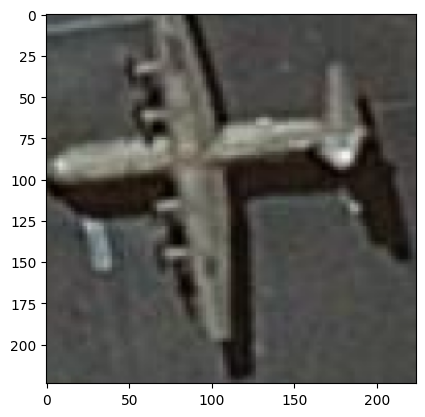

In [38]:
im = X_test[2]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

1/1 [==============================] - 1s 832ms/step


KeyboardInterrupt: 

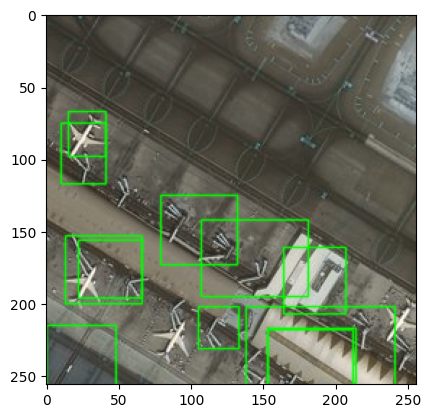

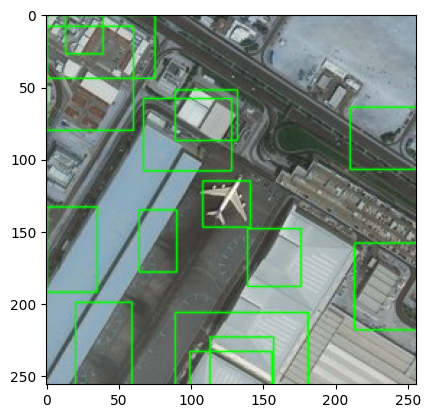

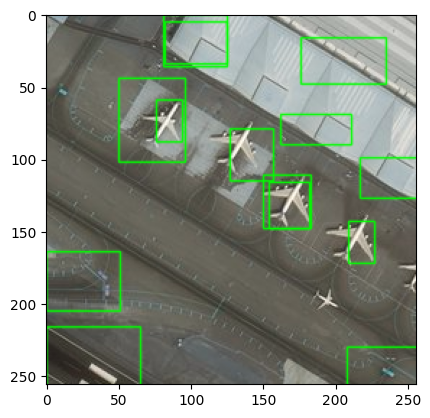

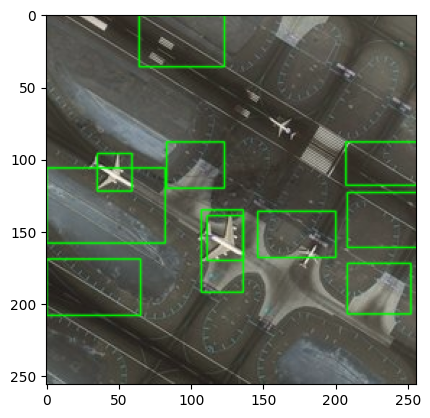

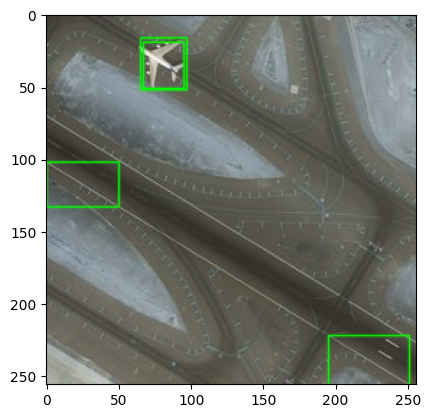

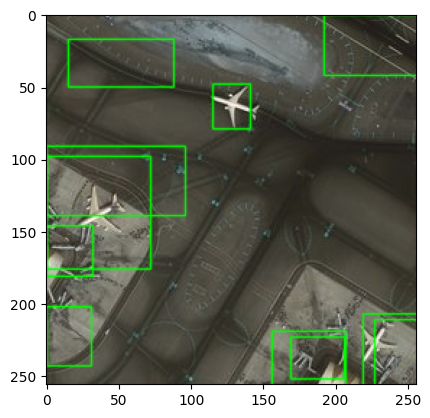

In [39]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 10:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)